In [317]:
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
from sklearn.datasets import load_iris
from sklearn.metrics.pairwise import euclidean_distances
import pandas as pd
from sklearn.cluster import KMeans
import random as rd


In [318]:
df = sns.load_dataset('iris')
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [319]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


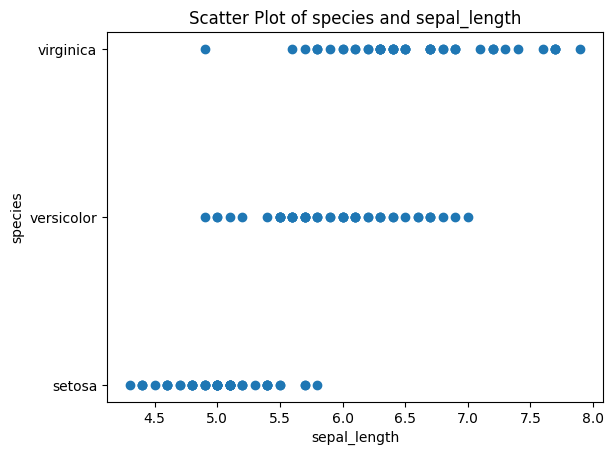

In [320]:
dfp = pd.DataFrame(df)

plt.scatter(dfp['sepal_length'], df['species'])
plt.xlabel('sepal_length')
plt.ylabel('species')
plt.title('Scatter Plot of species and sepal_length')
plt.show()

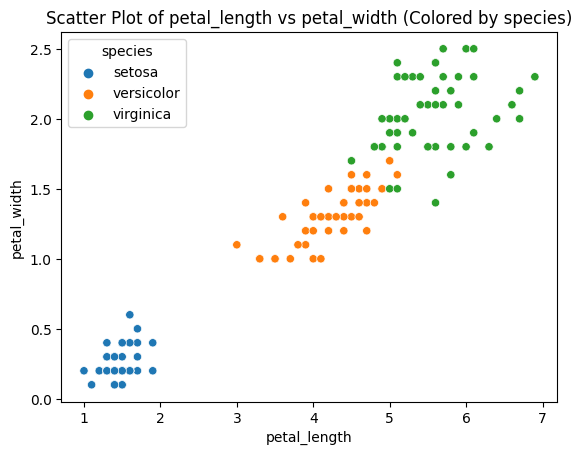

In [321]:
sns.scatterplot(x='petal_length', y='petal_width', hue='species', data=df)

plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.title('Scatter Plot of petal_length vs petal_width (Colored by species)')
plt.show()

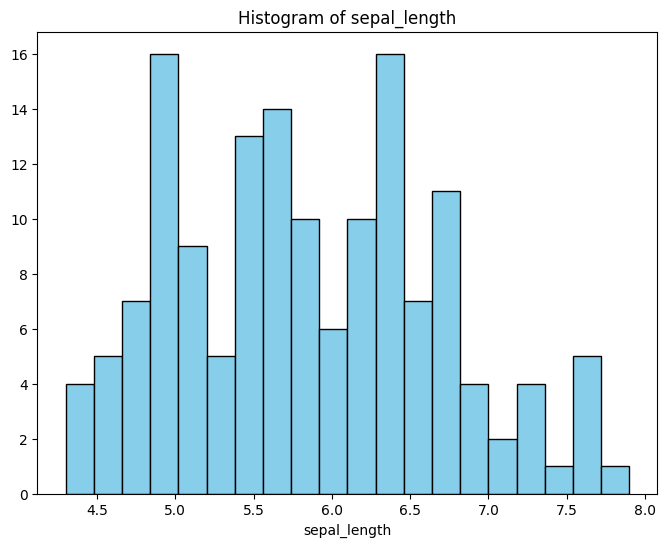

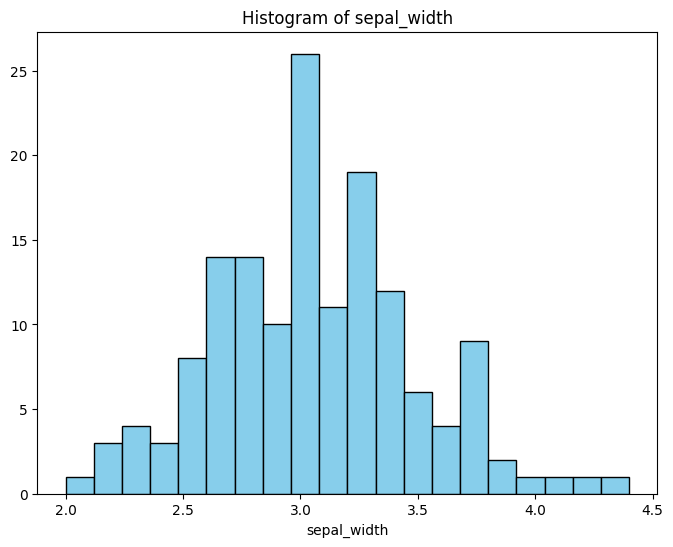

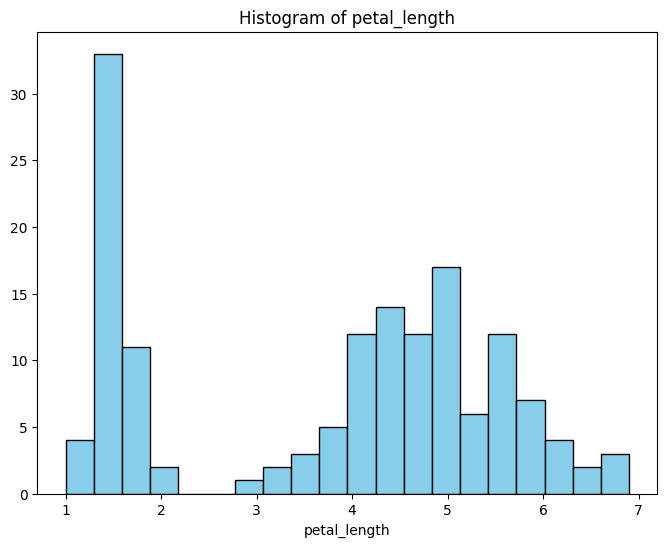

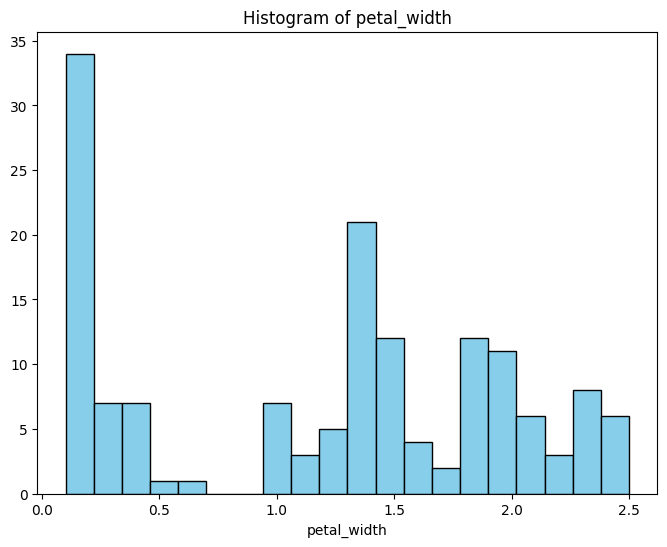

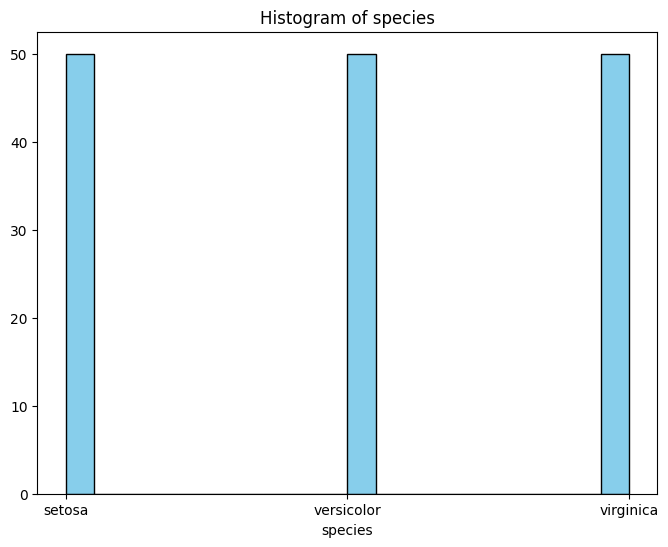

In [322]:
for column in df.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.show()

In [323]:
df.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [324]:
data = df.drop('species', axis=1)

In [325]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

In [326]:
length = len(data)
print("length", length)

length 150


In [327]:
from scipy.stats import zscore
z_scores = zscore(data_pca)
outliers = (np.abs(z_scores) > 3).any(axis=1)


if outliers.any():
    print("Outliers detected in the dataset.")
    print("Indices of outliers:")
    print(np.where(outliers)[0])
else:
    print("No outliers detected in the dataset.")

No outliers detected in the dataset.


In [328]:
def initialize_population(population_size, num_data_points, max_clusters):
    population = [np.append(np.random.randint(1, max_clusters + 1, size=num_data_points), max_clusters)
                  for i in range(population_size)]
    return population

def compute_fitness(total_distance):
    return 1.0 / (total_distance + 0.00000001)

def fitness_function(individual, data_points,num_clusters):
    cluster_assignments = individual[:-1]
    num_clusters = int(individual[-1])

    cluster_centroids = np.zeros((num_clusters, data_points.shape[1]))

    sum_squared_distances = 0.0

    for cluster in range(1, num_clusters + 1):
        cluster_data = data_points[cluster_assignments == cluster]

        if len(cluster_data) > 0:
            cluster_centroid = np.mean(cluster_data, axis=0)
            cluster_centroids[cluster - 1] = cluster_centroid

            distances_within_cluster = euclidean_distances(cluster_data, [cluster_centroid])
            sum_squared_distances += np.sum(distances_within_cluster ** 2)

    total_distance = sum_squared_distances
    fitness = compute_fitness(total_distance)

    return fitness

def selection(population, fitness_values, tournament_size=3):

    tournament_candidates = np.random.choice(len(population), size=tournament_size, replace=False)
    selected_candidates = [population[i] for i in tournament_candidates]

    fitness_candidates = [fitness_values[candidate] for candidate in tournament_candidates]
    parent1 = selected_candidates[np.argmax(fitness_candidates)]
    tournament_candidates = np.delete(tournament_candidates, np.argmax(fitness_candidates))

    fitness_candidates = np.delete(fitness_candidates, np.argmax(fitness_candidates))

    parent2 = selected_candidates[np.argmax(fitness_candidates)]

    return parent1, parent2


def crossover(parent1, parent2, crossover_rate=0.6):
  rate = np.random.rand() < crossover_rate
  offspring1 = np.where(rate, parent1, parent2)
  offspring2 = np.where(rate, parent2, parent1)
  return offspring1, offspring2



def mutation(individual, mutation_rate, num_clusters):
    size = len(individual)
    mutated_individual = individual.copy()

    for i in range(size):
        if random.random() < mutation_rate:
            new_cluster = random.randint(1, num_clusters)
            mutated_individual[i] = new_cluster

    return mutated_individual



def replacement(parent_population, offspring_population, population_size):
    combined_population = parent_population + offspring_population
    combined_population.sort(key=lambda x: fitness_function(x, data, num_clusters=3), reverse=True)
    next_generation = combined_population[:population_size]
    return next_generation


In [329]:
population_size = 15
num_data_points = length
max_clusters = 3
num_generations = 100
mutation_rate = 0.1

crossover_rate=0.6


initial_population = initialize_population(population_size, num_data_points, max_clusters)
fitness_values = [fitness_function(chromosome, data, num_clusters=3) for chromosome in initial_population]

best_solution = None
best_fitness = float('-inf')

for generation in range(num_generations):

    parent1,parent2 = selection(initial_population, fitness_values, tournament_size=3)


    offspring1, offspring2 = crossover(parent1, parent2,crossover_rate)
    if np.random.rand() < mutation_rate:
      offspring1 = mutation(offspring1, mutation_rate,max_clusters)
    if np.random.rand() < mutation_rate:
      offspring2 = mutation(offspring2, mutation_rate,max_clusters)


    initial_population = replacement(initial_population, [offspring1, offspring2], population_size)

    fitness_values = [fitness_function(chromosome, data, num_clusters=3) for chromosome in initial_population]

    current_best_fitness = max(fitness_values)
    print(f"Generation {generation + 1}, {current_best_fitness}")

    if current_best_fitness > best_fitness:
        best_solution = initial_population[np.argmax(fitness_values)]
        best_fitness = current_best_fitness


print(f"Best Solution: {best_solution}")



Generation 1, 0.0015295746754560137
Generation 2, 0.0015295746754560137
Generation 3, 0.0015295746754560137
Generation 4, 0.0015295746754560137
Generation 5, 0.0015295746754560137
Generation 6, 0.0015295746754560137
Generation 7, 0.0015295746754560137
Generation 8, 0.0015295746754560137
Generation 9, 0.0015295746754560137
Generation 10, 0.0015295746754560137
Generation 11, 0.0015295746754560137
Generation 12, 0.0015295746754560137
Generation 13, 0.0015295746754560137
Generation 14, 0.0015295746754560137
Generation 15, 0.0015295746754560137
Generation 16, 0.0015295746754560137
Generation 17, 0.0015295746754560137
Generation 18, 0.0015295746754560137
Generation 19, 0.0015295746754560137
Generation 20, 0.0015295746754560137
Generation 21, 0.0015295746754560137
Generation 22, 0.0015295746754560137
Generation 23, 0.0015371242150424163
Generation 24, 0.0015371242150424163
Generation 25, 0.0015371242150424163
Generation 26, 0.0015371242150424163
Generation 27, 0.0015371242150424163
Generation

In [330]:
dataframe = pd.DataFrame(data, columns =['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
pca = PCA(n_components=2)
datapc = pca.fit_transform(dataframe)
df_2 = pd.DataFrame(data = datapc, columns = ['component 1', 'component 2'])
best_cluster_assignments = best_solution[:-1]
dataframe1 = pd.DataFrame(best_cluster_assignments, columns =['Cluster'])
df_2.insert(0, "Cluster", dataframe1, True)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


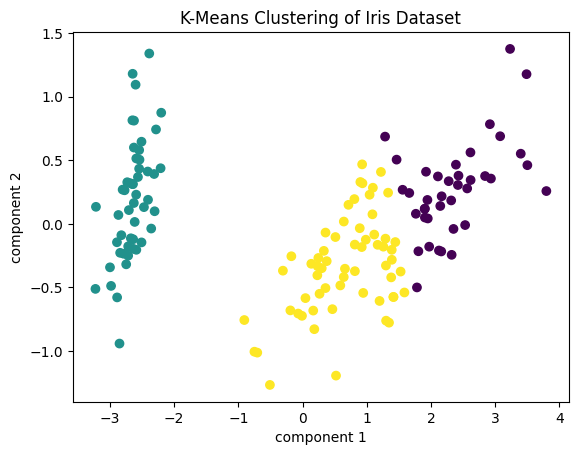

In [331]:
df_k = pd.DataFrame(data, columns =['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

pca_02 = PCA(n_components=2)
datapc_02 = pca.fit_transform(df_k)

ds_k = pd.DataFrame(data = datapc_02, columns = ['component 1', 'component 2'])
ds_k


kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(ds_k)

ds_k['Cluster'] = kmeans.labels_

plt.scatter(ds_k['component 1'], ds_k['component 2'], c=ds_k['Cluster'])
plt.title('K-Means Clustering of Iris Dataset')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<bound method _AxesBase.set_ylabel of <Axes: title={'center': 'Clustered data'}, xlabel='Component 1'>>

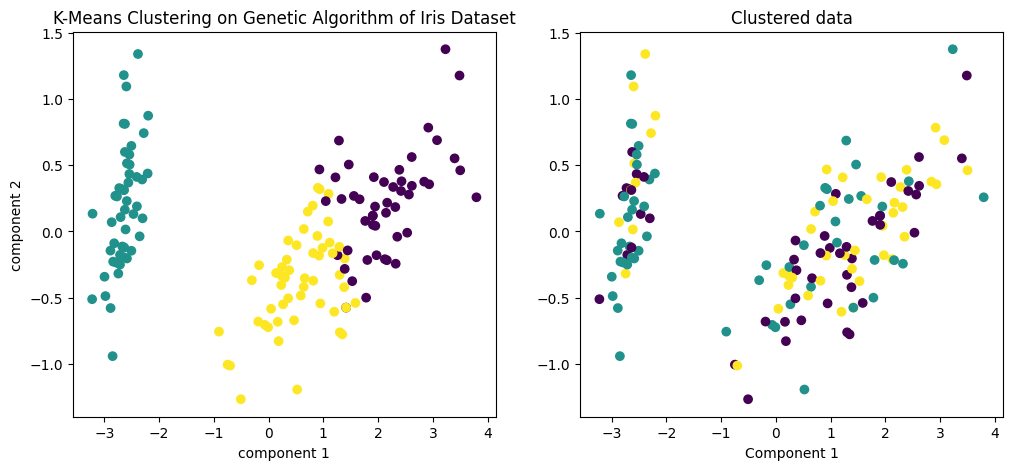

In [332]:
dataframe_01 = pd.DataFrame(data,  columns =['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
dataframe_01

pca_01 = PCA(n_components=2)
datapc_01 = pca.fit_transform(dataframe_01)

ds_01 = pd.DataFrame(data = datapc_01, columns = ['component 1', 'component 2'])


dataframe4 = pd.DataFrame(best_cluster_assignments, columns =['Cluster'])
ds_01.insert(0, "Cluster", dataframe4, True)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(ds_01)
ds_01['Cluster'] = kmeans.labels_

dataframe = pd.DataFrame(data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(dataframe)

df_2 = pd.DataFrame(data=principalComponents, columns=['component 1', 'component 2'])

best_cluster_assignments = best_solution[:-1]
dataframe1 = pd.DataFrame(best_cluster_assignments, columns=['Cluster'])
df_2.insert(0, "Cluster", dataframe1, True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].scatter(ds_01['component 1'], ds_01['component 2'], c=ds_01['Cluster'], cmap='viridis')
axes[0].set_title('K-Means Clustering on Genetic Algorithm of Iris Dataset')
axes[0].set_xlabel('component 1')
axes[0].set_ylabel('component 2')

axes[1].scatter(df_2['component 1'], df_2['component 2'], c=df_2['Cluster'])
axes[1].set_title('Clustered data')
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel

